Y-DATA 2020/21<br/>
Deep Learning HW2<br/>
Serge Tochilov

# Helper Modules

## cs231n.classifiers.neural_net

The loss function
$$L = -\dfrac{1}{N} \sum_{N,C} \mathbb{y}\ log\Big(f_{SM}\big(f_{ReLU}(X W_1 + \mathbb{b}_1)W_2 + \mathbb{b}_2\big)\Big)+\lambda \left(\sum W_1^2 + \sum W_2^2\right)$$

In [ ]:
import numpy as np
from scipy.special import softmax, xlogy
import copy
import requests
import io

par_list = ('W1', 'b1', 'W2', 'b2')

class TwoLayerNet(object):
    '''
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.
    In other words, the network has the following architecture:
    input - fully connected (FC) layer - ReLU - fully connected layer - softmax
    The outputs of the second fully-connected layer are the scores for each class.'''


    def __init__(self, input_size=3072, hidden_size=50, output_size=10, std=1e-4):
        '''
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:
            W1: First layer weights; has shape (D, H)
            b1: First layer biases; has shape (H,)
            W2: Second layer weights; has shape (H, C)
            b2: Second layer biases; has shape (C,)

        Inputs:
            - input_size: The dimension D of the input data.
            - hidden_size: The number of neurons H in the hidden layer.
            - output_size: The number of classes C.'''

        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        self.grads = {}
        self.init_grads()


    def init_grads(self):

        for par in par_list:
            self.grads[par] = np.empty_like(self.params[par])


    def loss(self, X, y=None, reg=0.0, ret_grads=True):
        '''
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
            - X: Input data of shape (N, D). Each X[i] is a training sample.
            - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
                an integer in the range 0 <= y[i] < C. This parameter is optional; if it
                is not passed then we only return scores, and if it is passed then we
                instead return the loss and gradients.
            - reg: Regularization strength.

        Returns:
            If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
                the score for class c on input X[i].
            If y is not None, instead return a tuple of:
                - loss: Loss (data loss and regularization loss) for this batch of training
                    samples.
                - grads: Dictionary mapping parameter names to gradients of those parameters
                    with respect to the loss function; has the same keys as self.params. '''

        # unpack variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N, D = X.shape

        #############################################################################
        # TODO: Perform the forward pass, computing the class scores for the input. #
        # Store the result in the scores variable, which should be an array of      #
        # shape (N, C).                                                             #
        #############################################################################

        # FC1 -> ReLU -> FC2
        fc1 = X @ W1 + b1
        relu = np.clip(fc1, 0, None)
        scores = relu @ W2 + b2

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################
        
        # if the targets are not given then jump out, we're done
        if y is None:
            return scores

        #############################################################################
        # TODO: Finish the forward pass, and compute the loss. This should include  #
        # both the data loss and L2 regularization for W1 and W2. Store the result  #
        # in the variable loss, which should be a scalar. Use the Softmax           #
        # classifier loss.                                                          #
        #############################################################################

        # number of classes
        C = b2.shape[0]

        # compute one-hot for `y`
        y_oh = np.zeros((N, C), dtype=np.int)
        y_oh[np.arange(N), y] = 1

        # Softmax Loss (Softmax -> Cross-Entropy) + L2-regularization
        smax = softmax(scores, axis=1)
        del scores
        loss = (-np.sum(xlogy(y_oh, smax))/N +
            reg * (np.sum(np.square(W1)) + np.sum(np.square(W2))))

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        #############################################################################
        # TODO: Compute the backward pass, computing the derivatives of the weights #
        # and biases. Store the results in the grads dictionary. For example,       #
        # grads['W1'] should store the gradient on W1, and be a matrix of same size #
        #############################################################################

        # back propagation
        smax[np.arange(N), y] -= 1
        dh = np.dot(smax, W2.T)
        dz = np.dot(smax, W2.T) * (fc1 > 0)  # (N, H)

        # compute gradient for parameters
        self.grads['W2'] = np.dot(relu.T, smax) / N + 2 * reg * W2 # (H, C)
        self.grads['b2'] = np.sum(smax, axis=0) / N  # (C,)
        self.grads['W1'] = np.dot(X.T, dz) / N + 2 * reg * W1 # (D, H)
        self.grads['b1'] = np.sum(dz, axis=0) / N  # (H,)
        del fc1, relu, smax, dh, dz

        #############################################################################
        #                              END OF YOUR CODE                             #
        #############################################################################

        if ret_grads:
            return loss, copy.deepcopy(self.grads)
        else:
            return loss


    def train(self, X, y, X_val, y_val,
        learning_rate=1e-3, learning_rate_decay=0.95,
        reg=5e-6, num_iters=100, batch_size=200, verbose=False, out_step=100, out_path=None):
        '''
        Train this neural network using stochastic gradient descent.

        Inputs:
            - X: Numpy array of shape (N, D) giving training data.
            - y: Numpy array of shape (N,) giving training labels; y[i] = c means that
                X[i] has label c, where 0 <= c < C.
            - X_val: Numpy array of shape (N_val, D) giving validation data.
            - y_val: Numpy array of shape (N_val,) giving validation labels.
            - learning_rate: Scalar giving learning rate for optimization.
            - learning_rate_decay: Scalar giving factor used to decay the learning rate
                after each epoch.
            - reg: Scalar giving regularization strength.
            - num_iters: Number of steps to take when optimizing.
            - batch_size: Number of training examples to use per step.
            - verbose: boolean; if true print progress during optimization.
            
        Returns:
            - loss_history
            - train_acc_history
            - val_acc_history '''

        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        # use SGD to optimize the parameters in self.model
        loss_history = []
        train_acc_history = []
        val_acc_history = []
        best_val = 0

        for it in range(num_iters):

            #########################################################################
            # TODO: Create a random minibatch of training data and labels, storing  #
            # them in X_batch and y_batch respectively.                             #
            #########################################################################
            idx = np.random.choice(np.arange(num_train), batch_size)
            X_batch = X[idx]
            y_batch = y[idx]
            del idx
            
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            # compute loss and gradients using the current minibatch
            loss = self.loss(X_batch, y=y_batch, reg=reg, ret_grads=False)
            loss_history.append(loss)

            #########################################################################
            # TODO: Use the gradients in the grads dictionary to update the         #
            # parameters of the network (stored in the dictionary self.params)      #
            # using stochastic gradient descent. You'll need to use the gradients   #
            # stored in the grads dictionary defined above.                         #
            #########################################################################
            self.params['W1'][...] = self.params['W1'] - self.grads['W1'] * learning_rate
            self.params['b1'][...] = self.params['b1'] - self.grads['b1'] * learning_rate
            self.params['W2'][...] = self.params['W2'] - self.grads['W2'] * learning_rate
            self.params['b2'][...] = self.params['b2'] - self.grads['b2'] * learning_rate
            #########################################################################
            #                             END OF YOUR CODE                          #
            #########################################################################

            if it % out_step == out_step-1:
                
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)
                if val_acc > best_val:
                    best_val = val_acc

                    if out_path is not None:
                        for par in par_list:
                            fpath = f'{out_path}/{it+1:06d}.{val_acc:.4f}.{par:s}.nb'
                            with open(fpath, 'wb') as f:
                                np.save(f, self.params[par])

                if verbose:
                    print(f'iteration {it+1:d}/{num_iters:d} loss: {loss:f} val_acc: {val_acc:f} best_val: {best_val:f}')

            # every epoch, check train and val accuracy and decay learning rate
            if it % iterations_per_epoch == 0:

                # decay learning rate
                learning_rate *= learning_rate_decay

            del X_batch, y_batch

        return {
            'loss_history': loss_history,
            'train_acc_history': train_acc_history,
            'val_acc_history': val_acc_history}


    def predict(self, X):
        '''
        Use the trained weights of this two-layer network to predict labels for
        data points. For each data point we predict scores for each of the C
        classes, and assign each data point to the class with the highest score.

        Inputs:
            - X: A numpy array of shape (N, D) giving N D-dimensional data points to
                classify.

        Returns:
            - y_pred: A numpy array of shape (N,) giving predicted labels for each of
                the elements of X. For all i, y_pred[i] = c means that X[i] is predicted
                to have class c, where 0 <= c < C. '''

        ###########################################################################
        # TODO: Implement this function; it should be VERY simple!                #
        ###########################################################################

        y_pred = np.argmax(self.loss(X), axis=1)
        
        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################

        return y_pred


    def load_model(self, model):

        for par in par_list:
            response = requests.get(model[par])
            response.raise_for_status()
            self.params[par] = np.load(io.BytesIO(response.content))

        self.init_grads()

## cs231n.data_utils

In [ ]:
from six.moves import cPickle as pickle
import os

# !!! scipy.misc.imread is deprecated
#from scipy.misc import imread
from skimage.io import imread

cifar10_dir = 'cifar-10-batches-py'


def load_CIFAR_batch(filename):
    ''' Load single batch of cifar '''

    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')

    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype(np.float)
    Y = np.array(Y)

    return X, Y


def load_CIFAR10(ROOT):
    ''' Load all of cifar '''

    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, f'data_batch_{b:d}')
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)

    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    '''
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function. '''

    # load the raw CIFAR-10 data
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test

## cs231n.gradient_check

In [ ]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
    ''' 
    Naive implementation of numerical gradient of f at x

    Inputs:
        - f should be a function that takes a single argument
        - x is the point (numpy array) to evaluate the gradient at ''' 

    # evaluate function value at original point
    fx = f(x)
    grad = np.zeros_like(x)

    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])

    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]

        # increment by h
        x[ix] = oldval + h

        # evalute f(x + h)
        fxph = f(x)
        x[ix] = oldval - h

        # evaluate f(x - h)
        fxmh = f(x)

        # restore
        x[ix] = oldval 

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h)
        if verbose:
            print(ix, grad[ix])

        it.iternext() # step to next dimension

    return grad

# Implementing a Neural Network
The present exercise is adapted from Stanford's CS231N course.  

We will develop a neural network with fully connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# set default size of plots
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## The CIFAR dataset

In [ ]:
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz

--2021-03-16 11:39:34--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  65.0MB/s    in 2.5s    

2021-03-16 11:39:37 (65.0 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
# cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# load the raw CIFAR-10 data
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# as a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


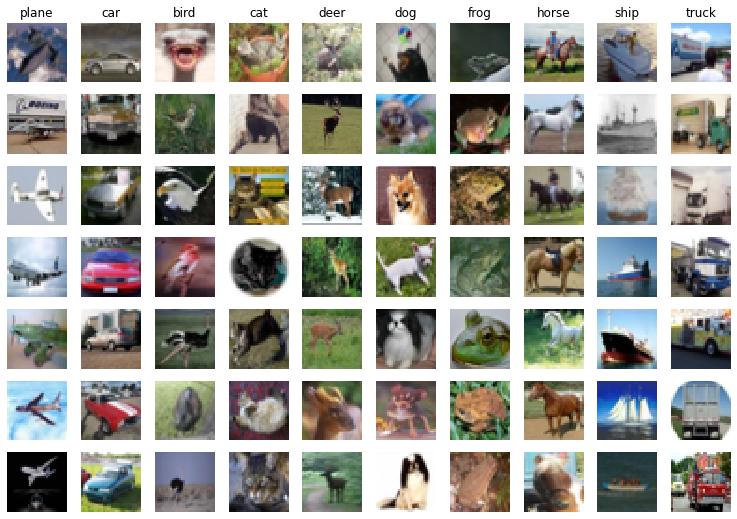

In [ ]:
# visualize some examples from the dataset;
# we show a few examples of training images from each class
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

plt.figure(figsize=(13, 9))

for y, cls in enumerate(classes):

    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)

    for i, idx in enumerate(idxs):

        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

## A 2-layer Neural Network

We will use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop your implementation.

In [ ]:
# create a small net and some toy data to check your implementations;
# note that we set the random seed for repeatable experiments

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

## Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the SVM and Softmax exercises. It takes the data and weights, and computes the class scores, the loss, and the gradients of the parameters.

Implement the first part of the forward pass, which uses the weights and biases to compute the scores for all inputs.

In [ ]:
scores = net.loss(X)
print('Your scores:')
print(scores)

correct_scores = np.asarray([
    [-0.81233741, -1.27654624, -0.70335995],
    [-0.17129677, -1.18803311, -0.47310444],
    [-0.51590475, -1.01354314, -0.8504215 ],
    [-0.15419291, -0.48629638, -0.52901952],
    [-0.00618733, -0.12435261, -0.15226949]])

# the difference should be very small, we get < 1e-7
print('\nDifference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


## Forward pass: compute loss
In the same function, implement the second part that computes the data and the regularization loss.

In [ ]:
loss, _ = net.loss(X, y, reg=0.05)
print('Your loss:')
print(loss)

correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('\nDifference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Your loss:
1.3037878913298202

Difference between your loss and correct loss:
1.7985612998927536e-13


## Backward pass
Implement the rest of the function that compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [ ]:
# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

def rel_error(x, y):
    ''' returns relative error '''
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

loss, grads = net.loss(X, y, reg=0.05)
f = lambda W: net.loss(X, y, reg=0.05)[0]

# these should all be less than 1e-8 or so
for param_name in grads:
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print(f'{param_name:s} max relative error: {rel_error(param_grad_num, grads[param_name])}')

W1 max relative error: 3.5613181785044393e-09
b1 max relative error: 2.7384195734507073e-09
W2 max relative error: 3.440707836450643e-09
b2 max relative error: 4.447645843629983e-11


## Train the network on toy data
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. Look at the function `TwoLayerNet.train` and fill in the missing sections to implement the training procedure. It should be very similar to the training procedure you used for the SVM and Softmax classifiers. You will also have to implement `TwoLayerNet.predict`, as the training process periodically performs prediction to keep track of accuracy over time while the network trains.

Once you implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

iteration 50/50: loss 0.018015 val_acc:1.000000
Final training loss:  0.018014559975315047


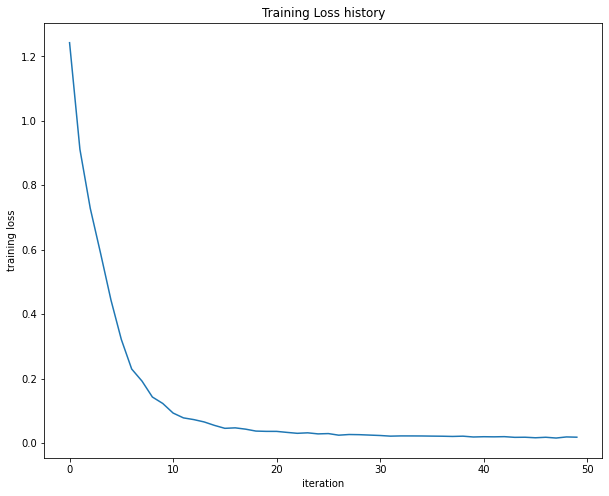

In [ ]:
import matplotlib.pyplot as plt

net = init_toy_model()
stats = net.train(X, y, X, y,
    learning_rate=1e-1, reg=5e-6,
    num_iters=50, verbose=True)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

## Load the full dataset
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data, so we can use it to train a classifier on a real dataset.

In [ ]:
# cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


## Train the network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds, e.g., after each epoch we will multiply the learning rate by some decay factor.

In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# train the network
stats = net.train(X_train, y_train, X_val, y_val,
    num_iters=1000, batch_size=200,
    learning_rate=1e-4, learning_rate_decay=0.95,
    reg=0.25, verbose=True)

# predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 100/1000 loss: 2.302596 val_acc: 0.213000 best_val: 0.213000
iteration 200/1000 loss: 2.295969 val_acc: 0.213000 best_val: 0.213000
iteration 300/1000 loss: 2.269856 val_acc: 0.182000 best_val: 0.213000
iteration 400/1000 loss: 2.201897 val_acc: 0.189000 best_val: 0.213000
iteration 500/1000 loss: 2.110192 val_acc: 0.225000 best_val: 0.225000
iteration 600/1000 loss: 2.054902 val_acc: 0.238000 best_val: 0.238000
iteration 700/1000 loss: 2.006968 val_acc: 0.255000 best_val: 0.255000
iteration 800/1000 loss: 2.059185 val_acc: 0.264000 best_val: 0.264000
iteration 900/1000 loss: 1.936456 val_acc: 0.279000 best_val: 0.279000
iteration 1000/1000 loss: 1.982758 val_acc: 0.281000 best_val: 0.281000
Validation accuracy:  0.281


## Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

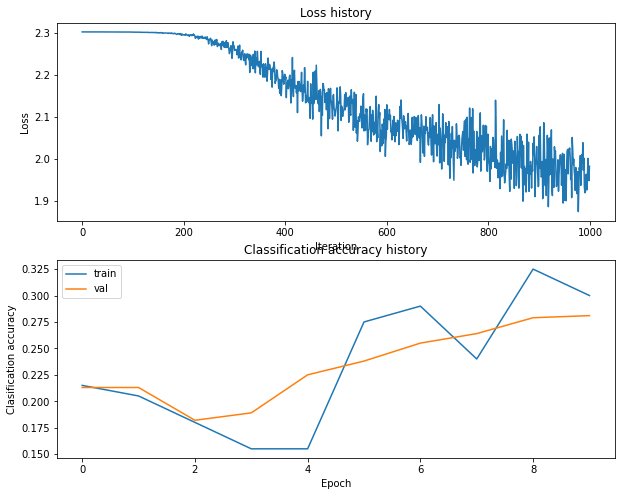

In [ ]:
# plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.legend()
plt.show()

In [ ]:
from math import sqrt, ceil


def visualize_grid(Xs, ubound=255.0, padding=1):
    '''
    Reshape a 4D tensor of image data to a grid for easy visualization.
    
    Inputs:
        - Xs: Data of shape (N, H, W, C)
        - ubound: Output grid will have values scaled to the range [0, ubound]
        - padding: The number of blank pixels between elements of the grid '''

    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H

    for y in range(grid_size):

        x0, x1 = 0, W

        for x in range(grid_size):

            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
            
        y0 += H + padding
        y1 += H + padding
    return grid

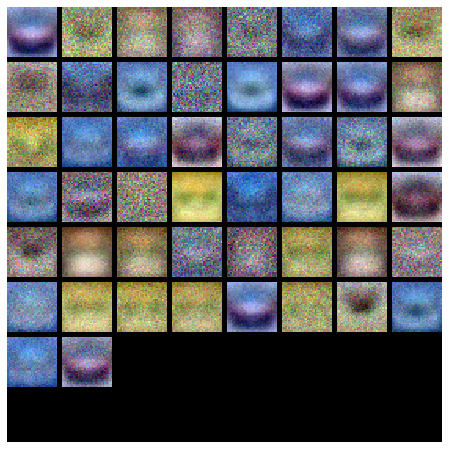

In [ ]:
# visualize the weights of the network
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

## Tune your hyperparameters

**What's wrong?** Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

> We used the following strategy to find the best network:
- Dramatically decreased the batch size from $200$ to $20$. This increased input randomness and allowed the net to fully benefit from the stocastic gradient descent
- Increased hidden layer to $250$. Higher values didn't improve the results but slowed iterations
- Increased number of iterations to $100000$
- During training process we periodically checked the validation accuracy and stored the best weights so far
- We retrained the network starting with initial learinig rate to explore more weight space. This added about $1\%$ to the best validation accuracy

>The best validation accuracy achieved is $58.1\%$ and the final test accuracy is $54.9\%$.

In [ ]:
def make_download_links(lnk):
    for k, v in lnk.items():
        lnk[k] = f'https://drive.google.com/uc?export=download&id={v.rsplit("/")[5]}'
    return lnk

model_0562 = make_download_links({
    'b1': 'https://drive.google.com/file/d/1MmihL0Or1SKIUq5s9R83eycUIfLwq1mD/view?usp=sharing',
    'b2': 'https://drive.google.com/file/d/1RtifERB6H9Lk6IwCVaj9MWZhfwUudRC0/view?usp=sharing',
    'W1': 'https://drive.google.com/file/d/1IDHJTfcnlFSO1pZaY9B1yxXtHPNFRTeC/view?usp=sharing',
    'W2': 'https://drive.google.com/file/d/19dD9983YL5T8a4oXesktsOFmEIu49jr9/view?usp=sharing',
})

model_0570 = make_download_links({
    'b1': 'https://drive.google.com/file/d/1ZCmZTKIeJAM8Vi99eolflt0U9WrJjrd6/view?usp=sharing',
    'b2': 'https://drive.google.com/file/d/1HcmffWMTn7y1Q0CaX1TNkZ7BtOm_9Zeo/view?usp=sharing',
    'W1': 'https://drive.google.com/file/d/1J8H4ce1gIkh4h2xF1YZzSiLInAt4W5ut/view?usp=sharing',
    'W2': 'https://drive.google.com/file/d/1DaCCuJF_3f8AJVnrgZExbLP_t-rsO8D_/view?usp=sharing',
})

model_0581 = make_download_links({
    'b1': 'https://drive.google.com/file/d/1mXbdAq4J7WD84q5TH4SyLGr7GnLxiPQN/view?usp=sharing',
    'b2': 'https://drive.google.com/file/d/1_iKDO0aQwkdcrXsV8BOJT11oiL6jtYo8/view?usp=sharing',
    'W1': 'https://drive.google.com/file/d/1y6YLF05ERTJ29KeEyGEky6wyexUa4XT2/view?usp=sharing',
    'W2': 'https://drive.google.com/file/d/1m3fm4itXzSQ-Twp1iB4mOdAzuWZe6nfe/view?usp=sharing',
})

In [ ]:
best_net = None # store the best model into this 

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_net.                                                            #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on the previous exercises.                          #
#################################################################################

best_net = TwoLayerNet()
best_net.load_model(model_0581)

#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

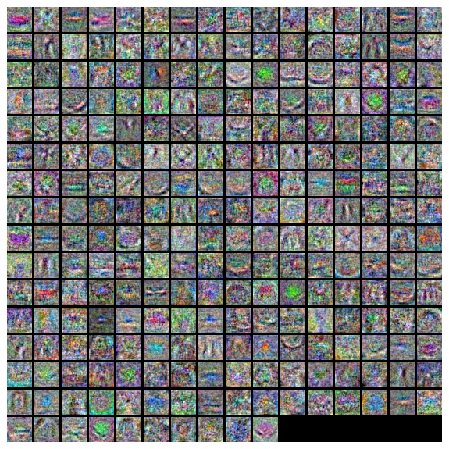

In [ ]:
# visualize the weights of the best network
show_net_weights(best_net)

## Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set, and you should get above 48%.

In [ ]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.549


**Inline Question**

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

>Answer:
1, 3

>Explanation:
By training on a larger dataset the network will have more diverse representation of possible inputs and would better generalize. More hidden units increase complexity of the network, so it will be able to learn on more complex inputs, but with small dataset it will overfit and further increase the train-test validation gap. Increasing the regularization strength has an effect of decreasing the network complexity, lowering overfitting, so the train-test validation gap is narrowing.